In [3]:
import os

import torch
import torch.nn as nn
from torch.optim import AdamW

from model.model import Model
from model.model_utils import set_seed, get_device, ModelTrainer
from data_utils.dataset import MzmlDataset
from data_utils.dataloader import Loader
from utils.io import create_dir

set_seed(42)

root = '/data/xp/train_test_data/astral_20231016_300ngPlasmaSample'
save_root = '/data/xp/result/astral_20231016_300ngPlasmaSample'
model_root = '/data/xp/model/astral_20231016_300ngPlasmaSample'

create_dir(save_root)
create_dir(model_root)

path_configs = {
    'root': root,
    'save_root': save_root,
    'train_data': os.path.join(root, 'train/identification/penalty_MAE_peaksum/collection.npy'),
    'test_data': os.path.join(root, 'test/identification/penalty_MAE_peaksum/collection.npy'),
    'train_save_path': os.path.join(save_root, 'train_identification.npy'),
    'test_save_path': os.path.join(save_root, 'test_identification.npy')
}

model_configs = {
    'd_in': 6,
    'num_layers': 4,
    'feedward_dim': 128,
    'n_head': 2,
    'dropout': 0.3,
    'd_out': 1
}

trainer_configs = {
    'save_path': os.path.join(model_root, 'identification.ckpt'),
    'n_epochs': 1000,
    'scheduler':{
        "warmup_steps": 25000,
        "total_steps": 500000,
    }
}

device = get_device()

loader = Loader(
    0.1,
    MzmlDataset,
    batch_size=8192,
    n_works=8
)

In [ ]:
def custom_metric_fn(input: torch.Tensor, target: torch.Tensor):
    temp = torch.zeros_like(input)
    temp[input < 0.5] = 0
    temp[input >= 0.5] = 1
    return -(temp == target).float().sum()

train_data, validation_data = loader.train_loader(path_configs['train_data'])

model = Model(
    **model_configs
)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-3)
criterion = nn.BCELoss(reduction='sum')

trainer = ModelTrainer(
    model,
    train_data,
    validation_data,
    optimizer,
    criterion,
    device=device,
    train_configs=trainer_configs,
    custom_metrics_name='accuracy',
    custom_metrics_fn=custom_metric_fn
)

loss_metrics, custom_metrics = trainer.train()

In [3]:
import torch
import numpy as np

from model.model import Model
from model.model_utils import ModelTester

model = Model(
    **model_configs
)

model_state = torch.load(trainer_configs['save_path'])
model.load_state_dict(model_state)
criterion = nn.BCELoss(reduction='sum')
model = model.to(device)

test_data, test_info = loader.test_loader(path_configs['test_data'])
train_data, train_info = loader.test_loader(path_configs['train_data'])

tester = ModelTester(
    model,
    test_data,
    criterion,
    device
)

In [4]:
from collections import defaultdict

from tqdm import tqdm
import numpy as np

def split_score_by_file(metadata):
    total = len(metadata['score'])
    dtype = np.dtype([('score', np.float32), ('flag', np.bool_), ('info', object)])
    info = metadata['info']
    score_split_by_file = defaultdict(list)

    for score, info in tqdm(zip(metadata['score'], metadata['info']), desc='split score by file', total=total):
        file = info[0]
        flag = True
        if 'DECOY-' in info[2][0]:
            flag = False

        score_split_by_file[file].append(
            np.array([(
                score, 
                flag, 
                (info[1], info[2])
            )],
            dtype=dtype
        ))

    for key in tqdm(score_split_by_file.keys(), desc='concat all the info in array dtype', total=len(score_split_by_file)):
        score_split_by_file[key] = np.concatenate(score_split_by_file[key], axis=0)

    score_split_by_file = dict(score_split_by_file)

    return score_split_by_file

# test data
tester.replace_dataloader(test_data)
test_score = tester.test(test_info)
test_score = split_score_by_file(test_score)
np.save(path_configs['test_save_path'], test_score)

# train data
tester.replace_dataloader(train_data)
train_score = tester.test(train_info)
train_score = split_score_by_file(train_score)
np.save(path_configs['train_save_path'], train_score)

loss:  0.4895509274262462 None:  0.0


concat all the info in array dtype: 100%|██████████| 189/189 [00:26<00:00,  7.21it/s]


loss:  0.24924755910650728 None:  0.0


concat all the info in array dtype: 100%|██████████| 131/131 [00:15<00:00,  8.61it/s]


In [4]:
import numpy as np
from collections import defaultdict

def peptide_identification(precursor_identification, library):
    identification = defaultdict(set)
    for f, precursors in precursor_identification.items():
        for precursor in precursors:
            identification[f].add(library[precursor]['StrippedPeptide'])
    return identification

def calculate_score_fdr_cutoff(scores, flag):
    indices = np.argsort(scores)[::-1]
    scores = scores[indices]
    flag = flag[indices]

    # initializing the two return values at 0
    numDecoys = 0

    # for every row in the dataframe
    count = 0
    for i in range(len(scores)):
        if not flag[i]: numDecoys += 1
        # calculates the FDR up to this point in the data frame.
        curFDR = numDecoys/(count+1)

        # conditional statement comparing the current FDR to the FDR Cutoff. If larger, function values are returned.
        if curFDR > 0.01:

            # if the number of rows has not yet reached the minimum number that allows for the FDR cutoff, 0 is returned instead.
            if count < 1/0.01: return -1
            return scores[i-1]
        count += 1

    return scores[-1]

def fdr(score_split_by_file):
    precursor_identification = defaultdict(set)
    for f, metadata in score_split_by_file.items():
        score, flag, info = metadata['score'], metadata['flag'], metadata['info']
        threshold = calculate_score_fdr_cutoff(metadata['score'], metadata['flag'])
        indices = (score >= threshold) & flag
        for item in info[indices]:
            precursor_identification[f].add(item[1])
    return precursor_identification

def calculate_overlap(sn, dl, get_overlap):
    length = len(sn)
    average_sn = 0
    average_dl = 0
    average_overlap = 0
    for f in sn.keys():
        average_sn += len(sn[f]) * 1/length
        average_dl += len(dl[f]) * 1/length
        average_overlap += len(get_overlap(sn[f], dl[f]))* 1/length
    return int(average_sn), int(average_overlap), int(average_dl)

test_score = np.load(path_configs['test_save_path'], allow_pickle=True).item()

dl_precursor_result = fdr(test_score)
library = np.load('/data/xp/library/AD8_Trypsin_Astral_directDIALibrary_Top6_Target_DecoyPsps23_SumNorm.npy', allow_pickle=True).item()
sn_train = np.load('/data/xp/label/astral_20231016_300ngPlasmaSample/train_identification.npy', allow_pickle=True).item()
sn_test = np.load('/data/xp/label/astral_20231016_300ngPlasmaSample/test_identification.npy', allow_pickle=True).item()
dl_peptide_result = peptide_identification(dl_precursor_result, library)
sn_train_peptide_result = peptide_identification(sn_train, library)
sn_test_peptide_result = peptide_identification(sn_test, library)

precursor_train_left, precursor_train_overlap, precursor_train_right = calculate_overlap(sn_train, dl_precursor_result, lambda x, y: x & y)
precursor_test_left, precursor_test_overlap, precursor_test_right = calculate_overlap(sn_test, dl_precursor_result, lambda x, y: x & y)
peptide_train_left, peptide_train_overlap, peptide_train_right = calculate_overlap(sn_train_peptide_result, dl_peptide_result, lambda x, y: x & y)
peptide_test_left, peptide_test_overlap, peptide_test_right = calculate_overlap(sn_test_peptide_result, dl_peptide_result, lambda x, y: x & y)

In [5]:
peptide_test_left, peptide_test_overlap, peptide_test_right

(10470, 7934, 8685)

In [6]:
peptide_train_left, peptide_train_overlap, peptide_train_right

(11074, 9062, 10118)

In [7]:
precursor_test_left, precursor_test_overlap, precursor_test_right

(15539, 11421, 12454)

In [8]:
precursor_train_left, precursor_train_overlap, precursor_train_right

(16432, 13075, 14521)

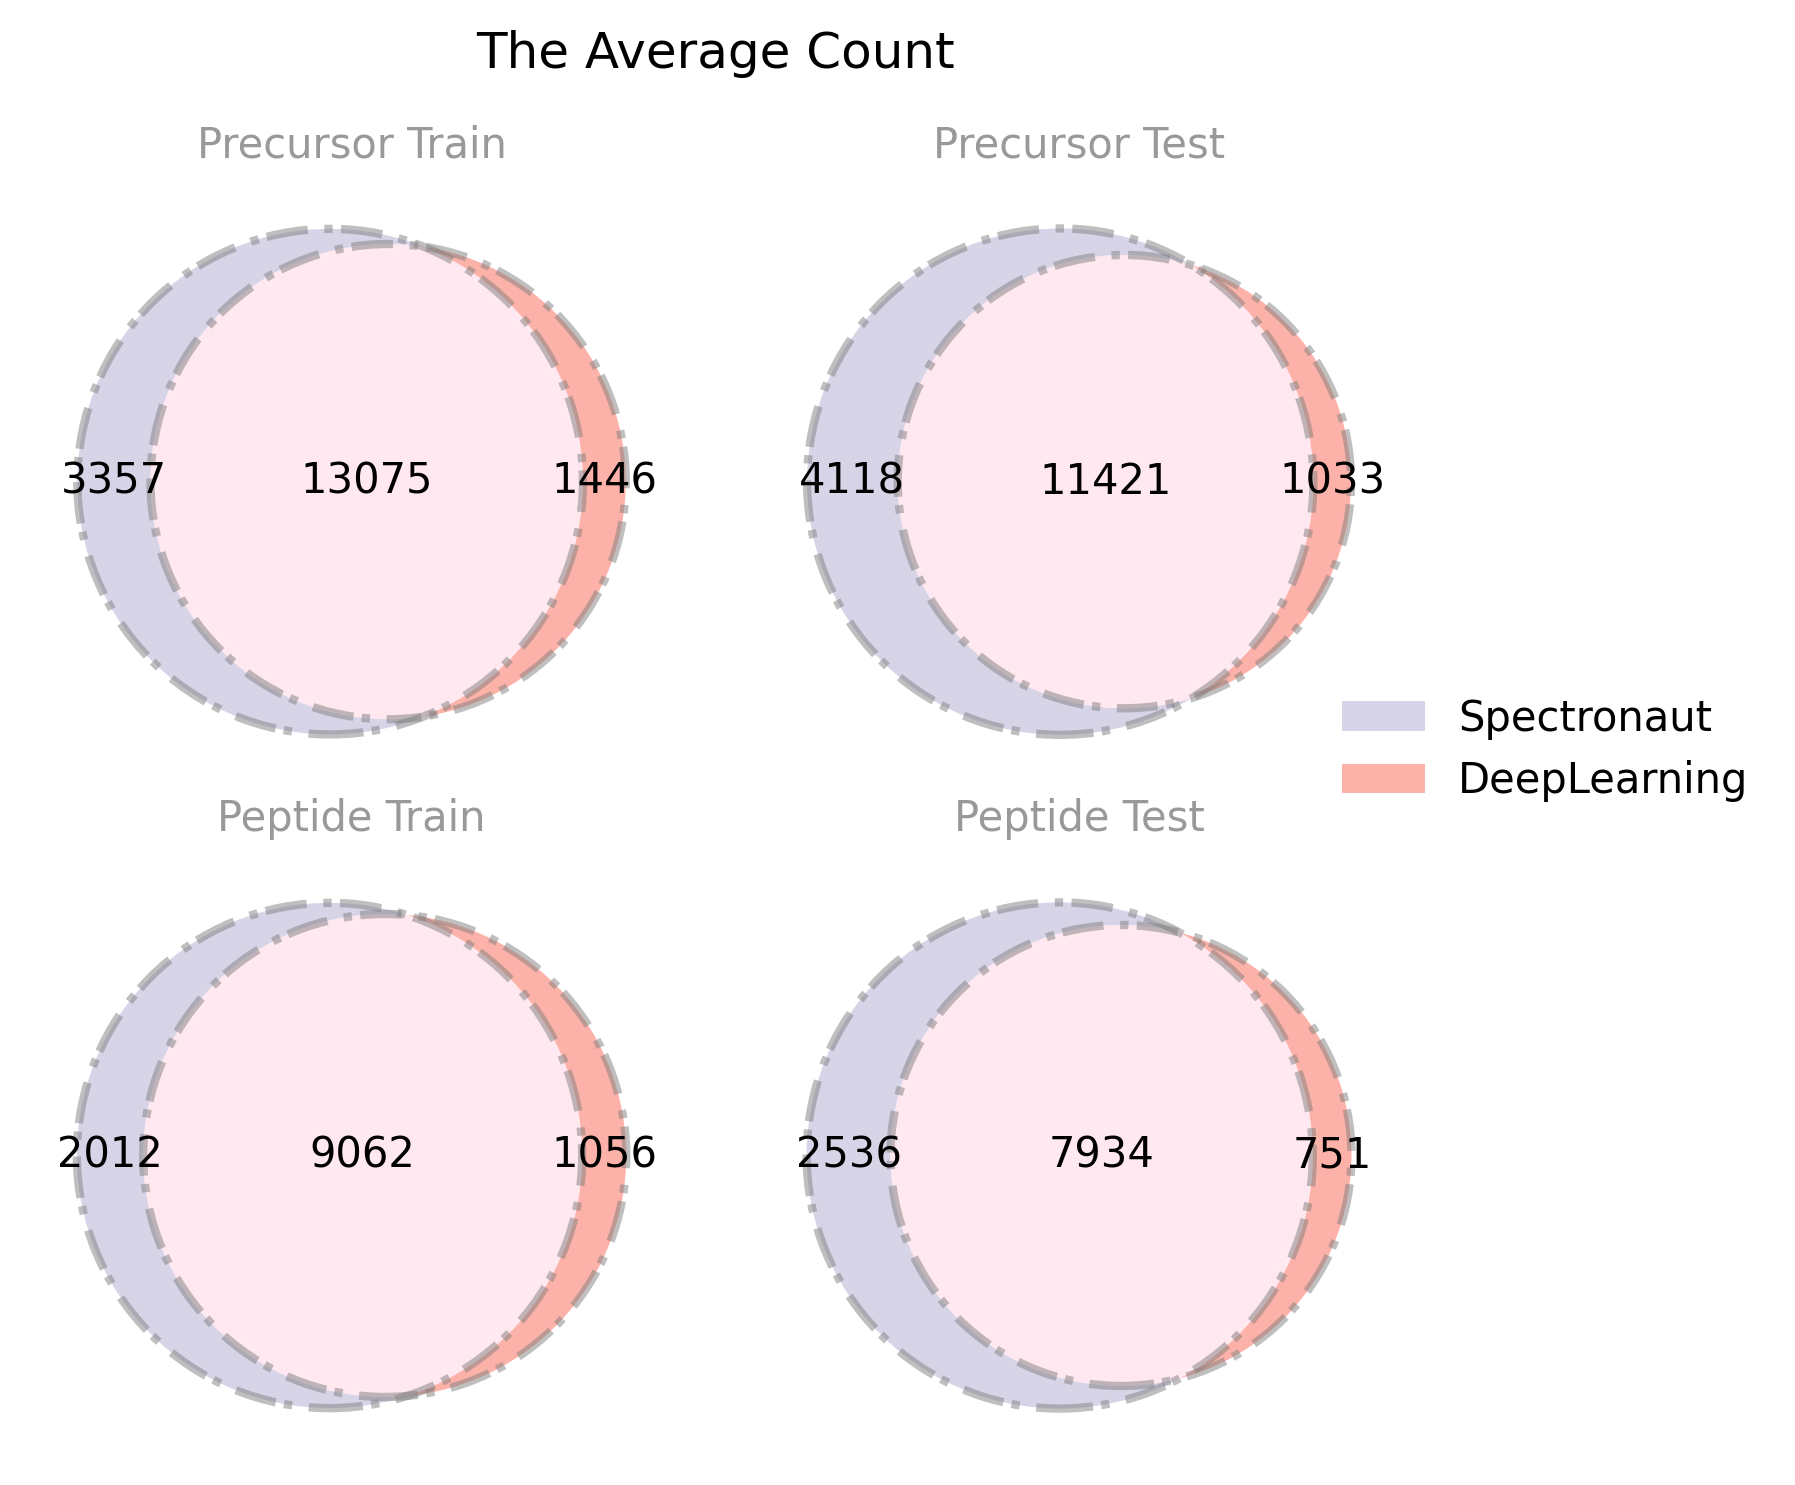

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from matplotlib_venn import venn2, venn2_circles

def plot_venn(left, overlap, right, sub_title, fig_suptitle):
    fig, ax = plt.subplots(2, 2, figsize=(5, 5), dpi=300)

    for i, (l, r, o) in enumerate(zip(left, right, overlap)):
        row, col = i // 2, i % 2
        venn2(
            subsets=(l-o, r-o, o),
            set_labels=('', ''),
            set_colors=('#BEB8DA', '#FA7F6F'),
            alpha=0.6,
            ax=ax[row][col]
        )

        venn2_circles(
            subsets=(l-o, r-o, o),
            linestyle=(1, (5, 1, 1, 2)),  # type: ignore
            linewidth=2.0,
            color='gray',
            alpha=0.5,
            ax=ax[row][col]
        )
        ax[row][col].set_title(sub_title[i], fontsize=10, color='gray', alpha=0.8)
    handles = [Patch(facecolor=color, alpha=0.6) for color in ('#BEB8DA', '#FA7F6F')]
    labels = ['Spectronaut', 'DeepLearning']
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize=10, ncol=1, borderaxespad=0., frameon=False)
    fig.suptitle(fig_suptitle)
    fig.tight_layout()
    return fig

figure = plot_venn(
    (precursor_train_left, precursor_test_left, peptide_train_left, peptide_test_left),
    (precursor_train_overlap, precursor_test_overlap, peptide_train_overlap, peptide_test_overlap),
    (precursor_train_right, precursor_test_right, peptide_train_right, peptide_test_right),
    sub_title=['Precursor Train', 'Precursor Test', 'Peptide Train', 'Peptide Test'],
    fig_suptitle='The Average Count'
)

figure.savefig('Average Count.png', dpi=500, bbox_inches='tight', facecolor='none')

### 绘制某个文件的模型打分情况

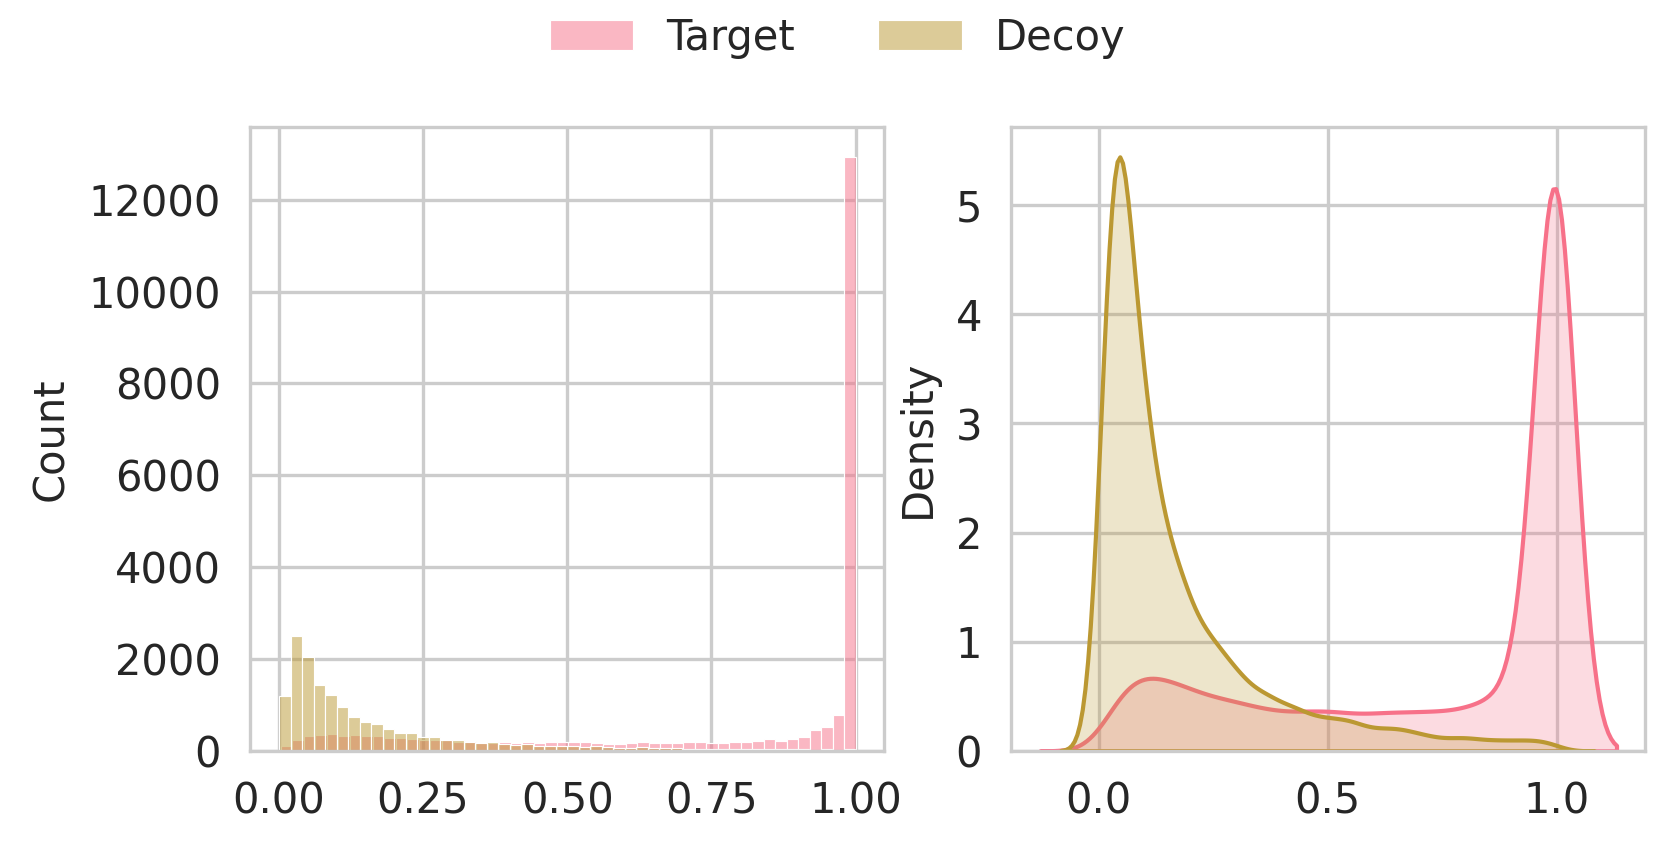

In [2]:
from typing import Sequence

import numpy as np
import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt


def plot_score_distribution(file, predcition):
    sns.set_style('whitegrid')
    sns.set_palette('husl')

    ax: Sequence[Axes]
    fig, ax = plt.subplots(1, 2, figsize=(6, 2.7), dpi=300)

    data = predcition[file]
    
    score = data['score']
    flag = data['flag']

    sns.histplot(data=score[flag], ax=ax[0], label='Target', bins=50, alpha=0.5)
    sns.histplot(data=score[~flag], ax=ax[0], label='Decoy', bins=50, alpha=0.5)

    sns.kdeplot(data=score[flag], ax=ax[1], label='Target', fill=True)
    sns.kdeplot(data=score[~flag], ax=ax[1], label='Decoy', fill=True)
    handles, labels = ax[0].get_legend_handles_labels()

    fig.legend(handles, labels, loc='upper center', ncol=2, borderaxespad=0., frameon=False)

test_score = np.load('/data/xp/result/astral_20231016_300ngPlasmaSample/test_identification.npy', allow_pickle=True).item()

plot_score_distribution('20231016_300ngPlasmaSample_7p5min_100um-13cm_P1-45', test_score)

### 计算 xic 曲线中六个子离子各自的相关系数

-   如果只匹配一个图谱，那么返回全 0 向量
-   如果匹配多个图谱，但是某个子离子一个实验图中的峰都没有匹配上
    -   将该离子去除
    -   对剩余离子的相关系数进行计算
    -   最后在对应位置补 0

In [37]:
import numpy as np

def calculate_xic_correlation(ex_ms2, mask):
    xic = ex_ms2[~mask, :, 1].T
    analysis_indices = np.any(xic > 0, axis=1).nonzero()[0]
    empty_indices = np.all(xic == 0, axis=1).nonzero()[0]
    xic = xic[analysis_indices]
    
    if xic.shape[1] == 1:
        return np.zeros(ex_ms2.shape[1])

    coeff = np.corrcoef(xic)
    index = np.sum(coeff, axis=1).argmax()
    corr_vec = coeff[index]
    for index in empty_indices:
        corr_vec = np.insert(corr_vec, index, 0)
    
    return corr_vec

In [ ]:
path = '/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/test/identification/penalty_MAE_peaksum/collection.npy'

data = np.load(path, allow_pickle=True)
label = []
for info in data['Info']:
    if 'DECOY-' in info[2][0]:
        label.append(0)
    else:
        label.append(1)

label = np.array(label)

target = data[label == 1]
decoy = data[label == 0]

coeffs = {
    'target': [],
    'decoy': []
}

correlation = calculate_xic_correlation(target['Ex_ms2'][5], target['Mask'][5])
print(correlation)
print(target['Ex_ms2'][5][~target['Mask'][5], :, 1])

length = 0

for i, (ex_ms2, mask) in enumerate(zip(target['Ex_ms2'], target['Mask'])):
    xic = ex_ms2[~mask, :, 1].T
    analysis_indices = np.any(xic > 0, axis=1).nonzero()[0]
    empty_indices = np.all(xic == 0, axis=1).nonzero()[0]
    if xic.shape[1] == 1:
        length += 1

print(length, length // 189)

In [44]:
ex_ms2, spectrum = target['Ex_ms2'], target['Spectrum']

In [67]:
def ppm(ex_ms2, spectrum):
    exms2_mz = ex_ms2[:, :, 0]
    s_mz = spectrum[:, :, 0]
    
    mz = np.full_like(exms2_mz, -1)
    empty_indices = (exms2_mz == 0).nonzero()
    non_empty_indices = (exms2_mz > 0).nonzero()

    mz[non_empty_indices] = exms2_mz[non_empty_indices]

    ppm_values = np.abs((s_mz - mz) / (mz * 1e-6))

    ppm_values[empty_indices] = -1

    return ppm_values

In [69]:
ppm(ex_ms2[0], spectrum[0]).shape

(10, 6)

### 绘制 xic 相关性分数分布图

-   对于所有数据

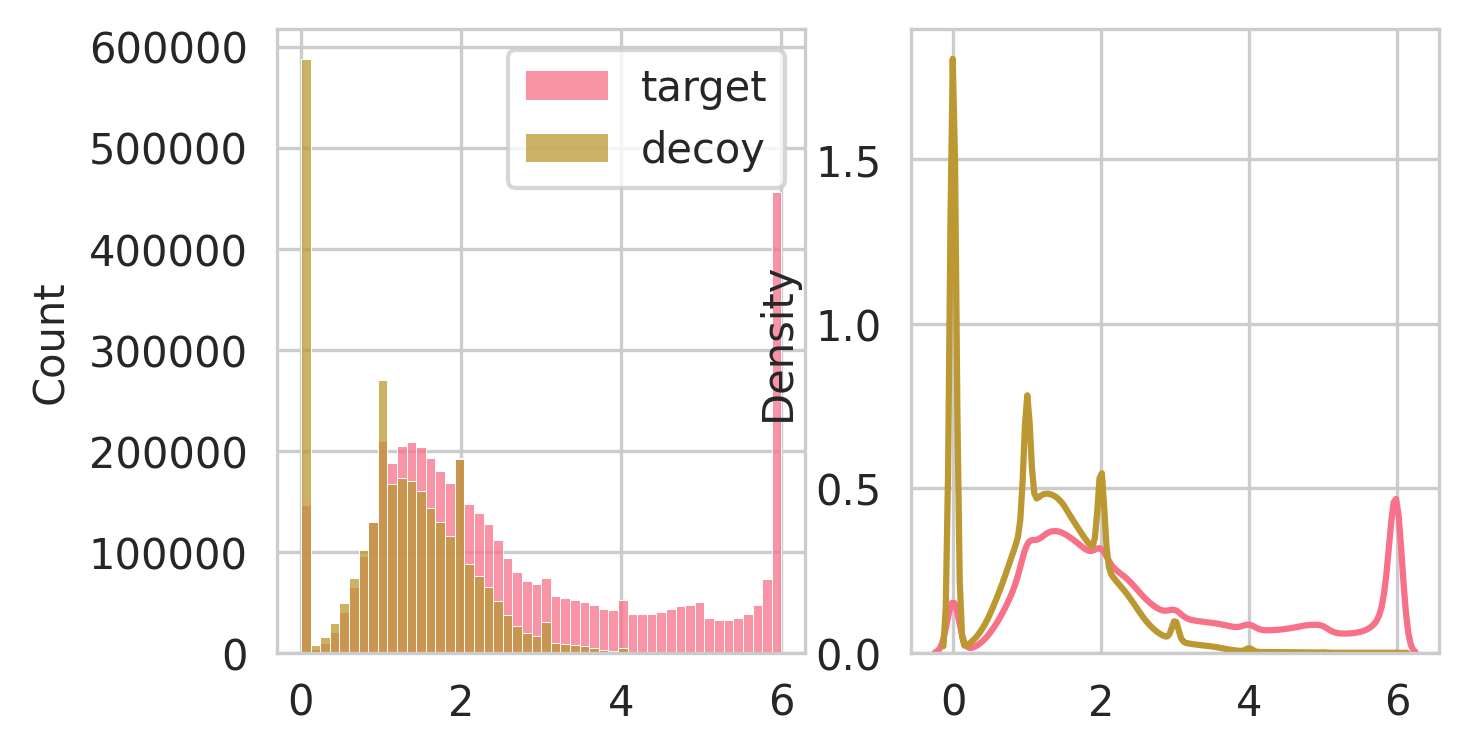

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('husl')

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(5, 2.7))

sns.histplot(coeffs['target'], ax=ax[0], bins=50, label='target')
sns.histplot(coeffs['decoy'], ax=ax[0], bins=50, label='decoy')

sns.kdeplot(coeffs['target'], ax=ax[1], label='target')
sns.kdeplot(coeffs['decoy'], ax=ax[1], label='decoy')

ax[0].legend()

### 直接使用最大相关系数和作为 fdr 控制分数

In [43]:
scores = np.array(coeffs['target']) + 1e-6
flag = np.ones(len(coeffs['target']), dtype=bool)

scores = np.append(scores, coeffs['decoy'])
flag = np.append(flag, np.zeros(len(coeffs['decoy']), dtype=bool))

indices = np.argsort(scores)[::-1]
scores = scores[indices]
flag = flag[indices]

cutoff = calculate_score_fdr_cutoff(scores, flag)

from collections import defaultdict

r = defaultdict(set)

for file, _, l in data['Info'][label.astype(bool)][np.array(coeffs['target'])>=cutoff]:
    r[file].add(l)

r = dict(r)

for f, val in r.items():
    print(f, len(val))

1192686

### 训练数据上 xic 相关系数分数分布图

-   下面的 target 都是 spectronaut 定性到的母离子

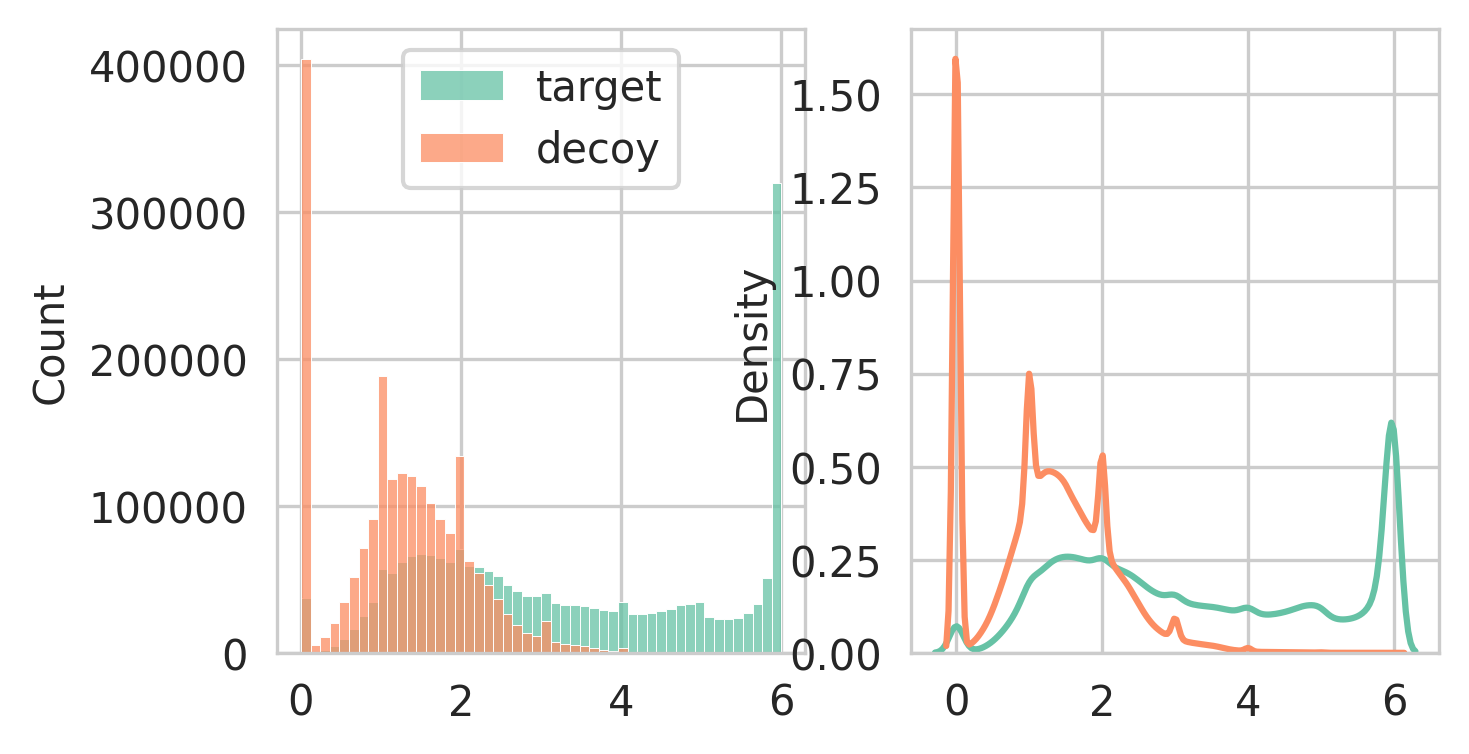

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set2')

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(5, 2.7))

sns.histplot(coeffs['target'], ax=ax[0], bins=50, label='target')
sns.histplot(coeffs['decoy'], ax=ax[0], bins=50, label='decoy')

sns.kdeplot(coeffs['target'], ax=ax[1], label='target')
sns.kdeplot(coeffs['decoy'], ax=ax[1], label='decoy')

ax[0].legend()

### 绘制模型训练/验证时的 loss 曲线以及自定义的误差曲线

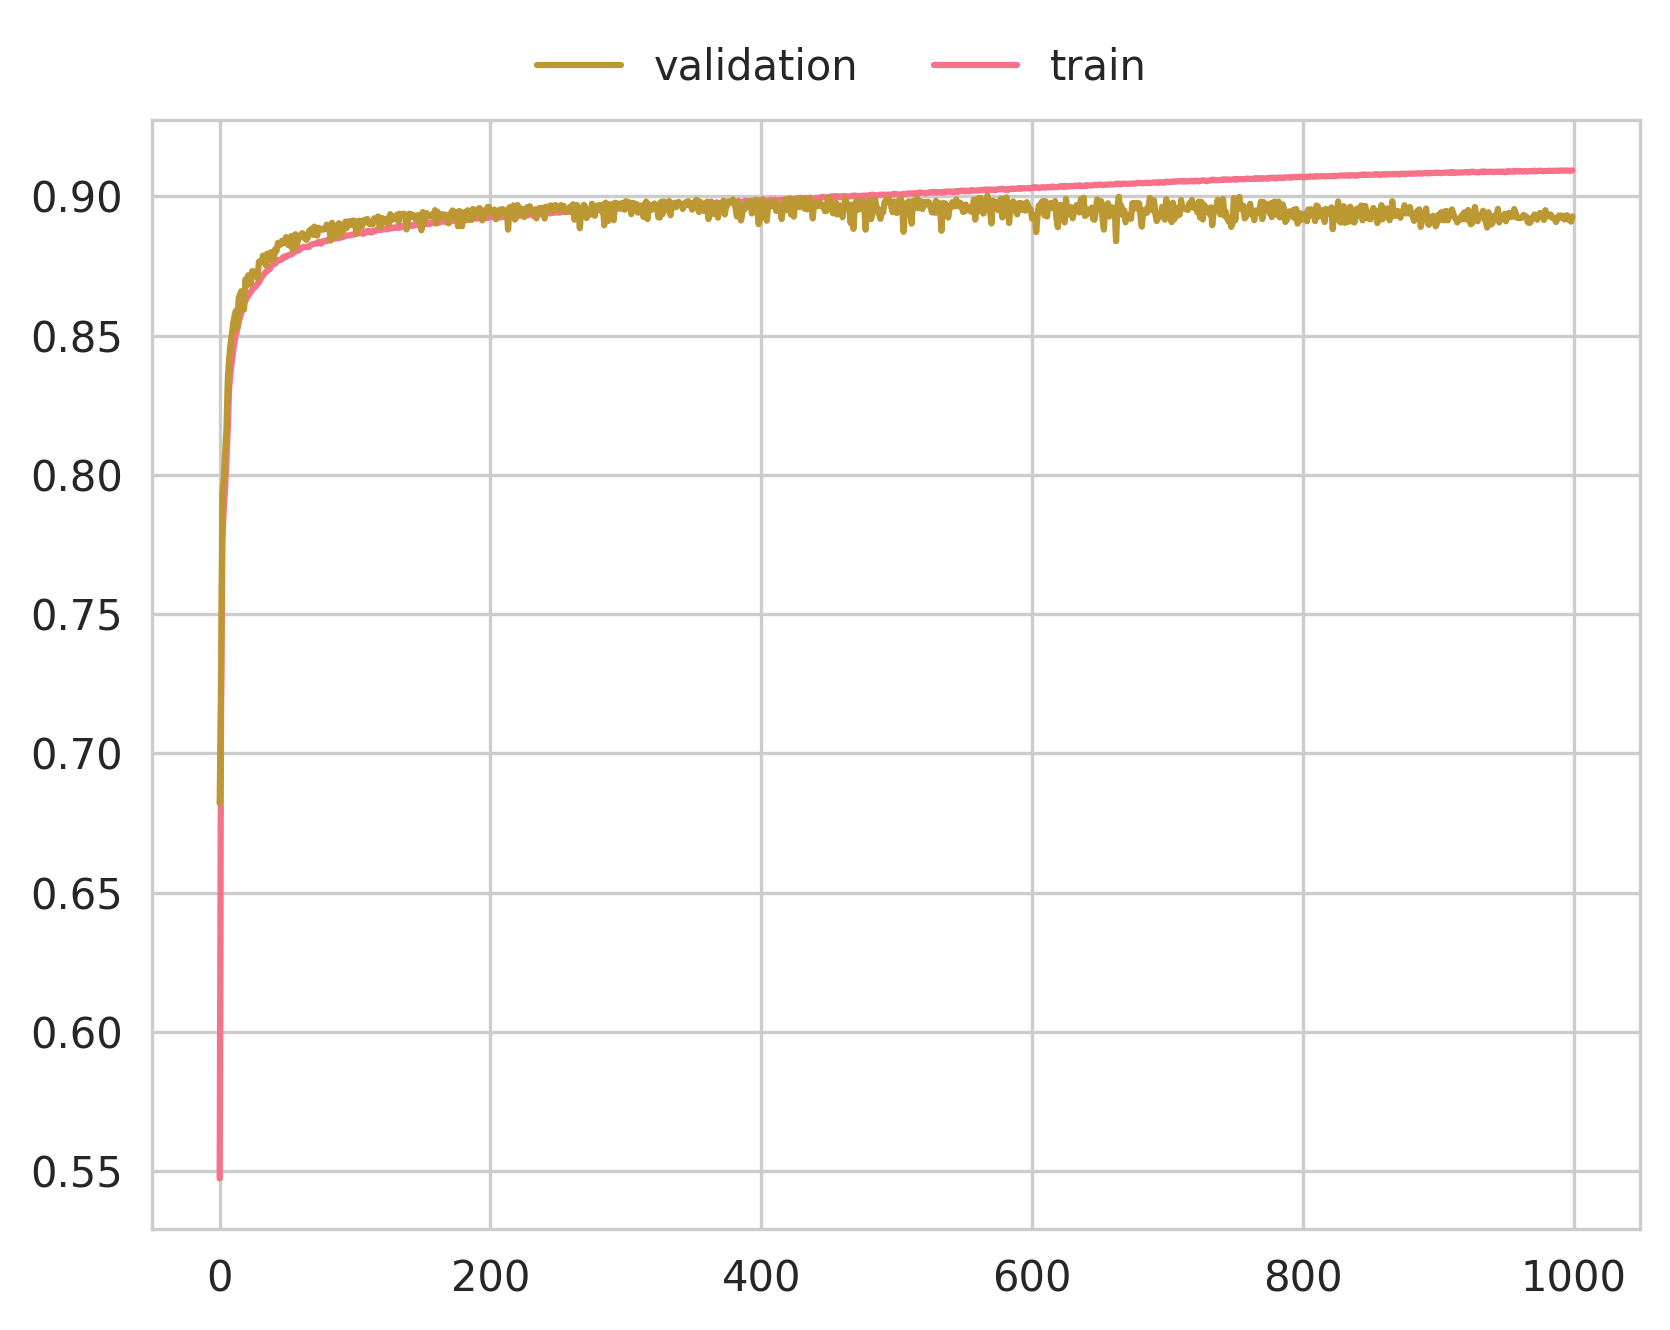

In [3]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

loss_metrics, custom_metrics = np.load('./loss_metrics.npy', allow_pickle=True).item(), np.load('./custom_metrics.npy', allow_pickle=True).item()

sns.set_style('whitegrid')
sns.set_palette('husl')

fig, ax = plt.subplots(1, 1, dpi=300)

sns.lineplot(np.abs(custom_metrics['train']), label='train', ax=ax)
sns.lineplot(np.abs(custom_metrics['validation']), label='validation', ax=ax)

ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1), frameon=False, mode='expand')

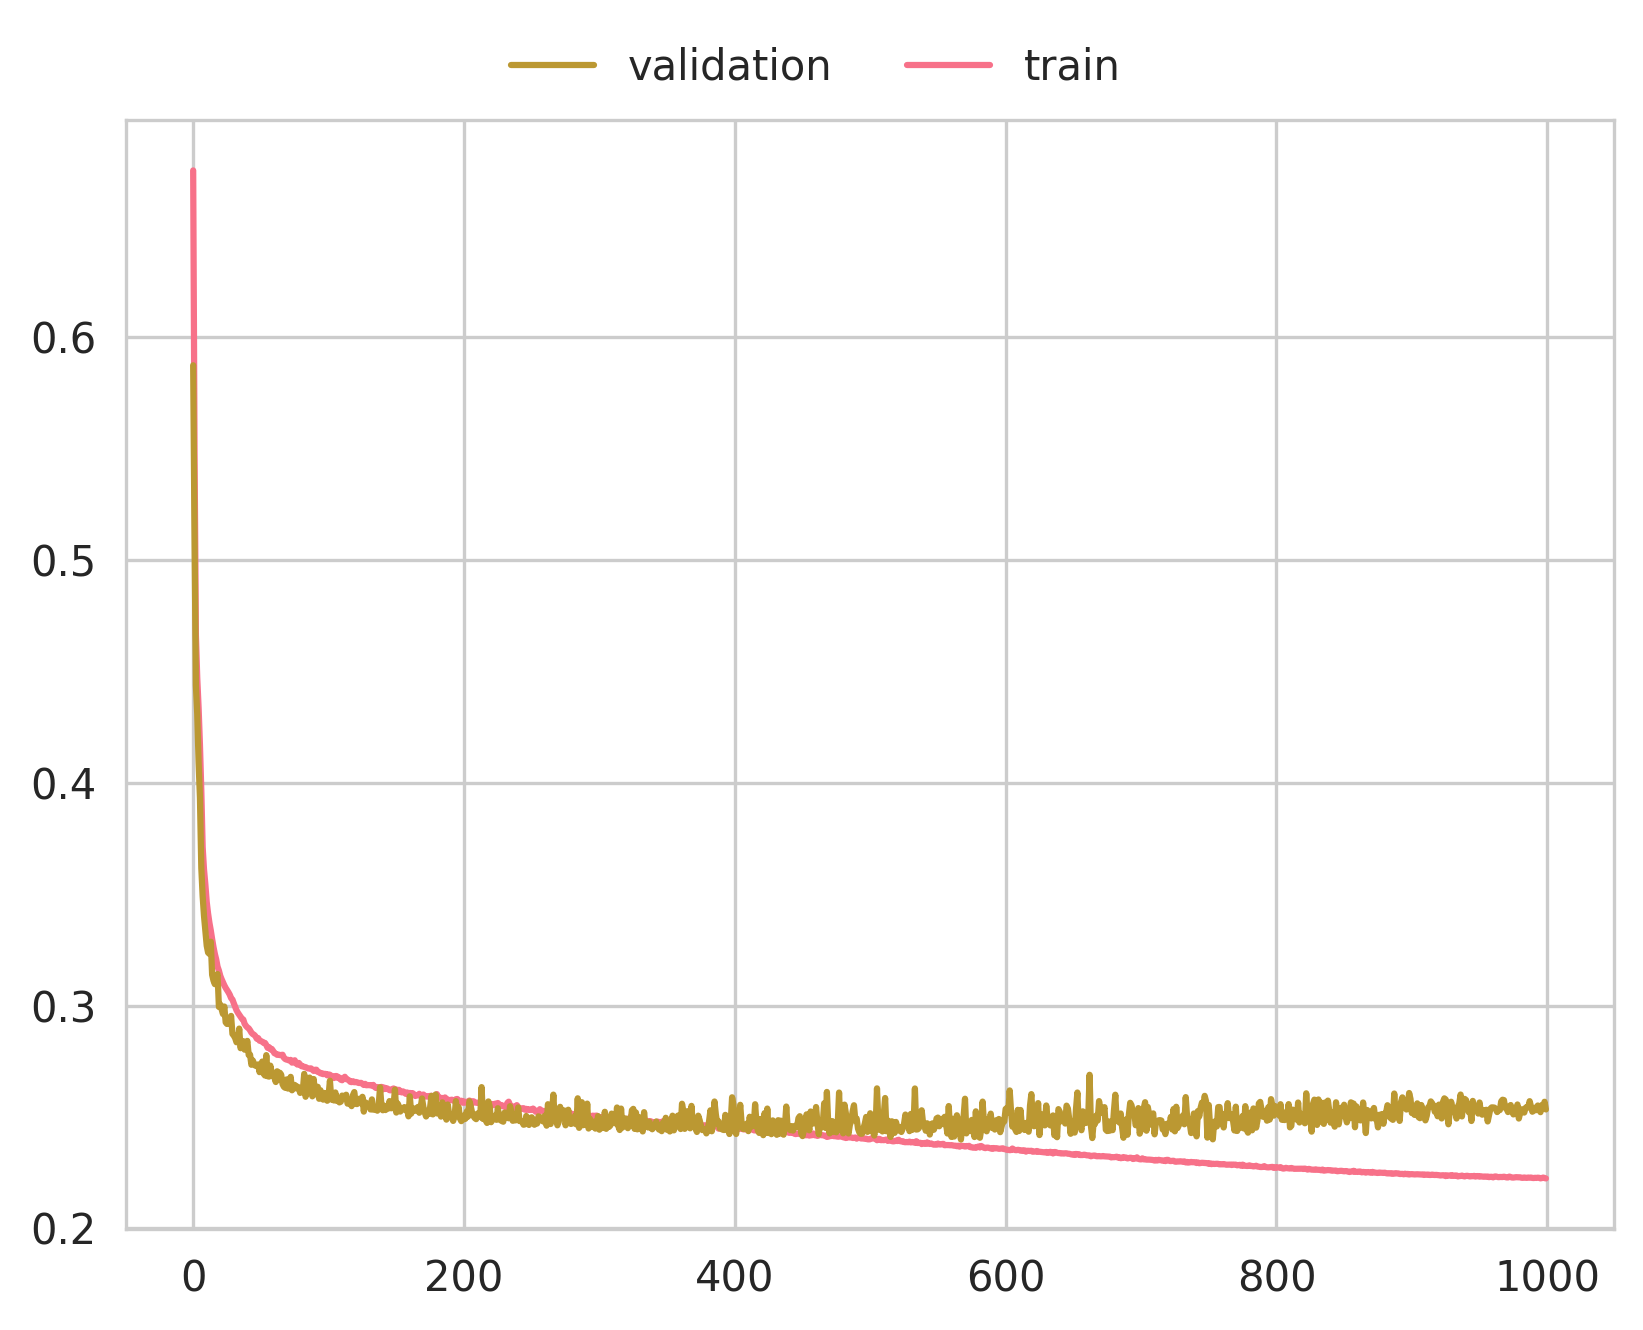

In [4]:
fig, ax = plt.subplots(1, 1, dpi=300)

start = 0
end = len(loss_metrics['train'])

sns.lineplot(x=np.arange(start, end), y=loss_metrics['train'][start:], label='train', ax=ax)
sns.lineplot(x=np.arange(start, end), y=loss_metrics['validation'][start:], label='validation', ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, mode='expand', frameon=False)

### 对模型进行可解释性分析

-   查看填补之后的 xic 图像
-   查看注意力生成的相关性分数
-   试图通过这些内容对模型进行可解释性分析

In [ ]:
from model.model import Model

class Viewer(Model):
    def __init__(self, num_layers: int, d_in: int, feedward_dim: int, n_head: int, d_out: int, dropout: float = 0.1) -> None:
        super().__init__(num_layers, d_in, feedward_dim, n_head, d_out, dropout)
    
    def forward(self, ex_ms2, spectrum, mask, featured_ion):
        ex_ms2, spectrum = ex_ms2[:, :, :, 1], spectrum[:, :, :, 1]

        coeff = self.coeff_block(ex_ms2)
        ex_ms2 = self.ex_dimtrans(coeff)
        ex_ms2, _ = self.ex_encoder(ex_ms2)
        ex_ms2 = self.selu(ex_ms2)
        ex_ms2, ex_ms2_attention_weight = self.coeff_attention(ex_ms2, ex_ms2, ex_ms2, key_padding_mask=mask)

        spectrum = self.pep_dimtrans(spectrum)
        x, spectrum_ex_ms2_attention_weight = self.blend_attention(spectrum, ex_ms2, ex_ms2, key_padding_mask=mask)
        x = torch.mean(x, axis=1)
        x = self.decoder(x)

        return x, coeff, ex_ms2_attention_weight, spectrum_ex_ms2_attention_weight

In [ ]:
data = np.load(path_configs['test_data'], allow_pickle=True)

In [ ]:
temp_data = data[:2]
ex_ms2, spectrum, featured_ion, mask, info = temp_data['Ex_ms2'], temp_data['Spectrum'], temp_data['Featured_ion'], temp_data['Mask'], temp_data['Info']

ex_ms2 = torch.tensor(ex_ms2, dtype=torch.float32)
spectrum = torch.tensor(spectrum, dtype=torch.float32)
mask = torch.tensor(mask, dtype=torch.float32)
featured_ion = torch.tensor(featured_ion, dtype=torch.float32)

viewer = Viewer(**model_configs)
model_state = torch.load(trainer_configs['save_path'])
viewer.load_state_dict(model_state)
viewer.eval()
score, coeff, ms2_atten, spe_ms2_atten = viewer(ex_ms2, spectrum, mask, featured_ion)

In [2]:
def a(*args):
    print(args[0])

a(1, 2, 3)

1
